## Lab Exame - CMC-13
### Equipe:
João Pedro Vieira

Pedro Ramos

Rafael Rocha

### 1. Preparação dos dados

#### Imports

In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import geopandas as gpd
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

In [303]:
df_train = pd.read_csv('./apartments_for_rent_train.csv', index_col=0, sep=',')
df_test = pd.read_csv('./apartments_for_rent_test.csv', index_col=0, sep=',')
print('Size of dfs are: \n\tdf_train:',
      df_train.shape,
      '\n\tdf_test:',
      df_test.shape)
df_train.head()

Size of dfs are: 
	df_train: (8001, 21) 
	df_test: (1799, 21)


,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,pets_allowed,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668626895,housing/rent/apartment,"Studio apartment 2nd St NE, Uhland Terrace NE,...","This unit is located at second St NE, Uhland T...",NaN,NaN,0.0,USD,No,NaN,...,$790,Monthly,101,NaN,Washington,DC,389.057,-769.861,RentLingo,1.577359e+09
1,5664597177,housing/rent/apartment,Studio apartment 814 Schutte Road,"This unit is located at 814 Schutte Road, Evan...",NaN,NaN,1.0,USD,No,NaN,...,$425,Monthly,106,814 Schutte Rd,Evansville,IN,379.680,-876.621,RentLingo,1.577017e+09
2,5668626833,housing/rent/apartment,"Studio apartment N Scott St, 14th St N, Arling...","This unit is located at N Scott St, 14th St N,...",NaN,1.0,0.0,USD,No,NaN,...,"$1,390",Monthly,107,NaN,Arlington,VA,388.910,-770.816,RentLingo,1.577359e+09
3,5659918074,housing/rent/apartment,Studio apartment 1717 12th Ave,"This unit is located at 1717 12th Ave, Seattle...",NaN,1.0,0.0,USD,No,NaN,...,$925,Monthly,116,1717 12th Avenue,Seattle,WA,476.160,-1.223.275,RentLingo,1.576668e+09
4,5668626759,housing/rent/apartment,"Studio apartment Washington Blvd, N Cleveland ...","This unit is located at Washington Blvd, N Cle...",NaN,NaN,0.0,USD,No,NaN,...,$880,Monthly,125,NaN,Arlington,VA,388.738,-771.055,RentLingo,1.577359e+09


Vamos avaliar a qualidade dos dados e prepará-los para a modelagem.

Vamos começar avaliando a quantidade de valores únicos que temos por coluna

In [304]:
df_train.nunique()

id               8001
category            3
title            7465
body             7963
amenities        2071
bathrooms           5
bedrooms            6
currency            1
fee                 1
pets_allowed        3
price            1515
price_display    1516
price_type          3
square_feet       888
address          5165
cityname         1331
state              50
latitude         2029
longitude        2024
source             12
time             5347
dtype: int64

Vemos que podemos retirar as colunas `currency` e  `fee`, uma vez que elas apresentam apenas um valor único. Todas os dados estão em dólares e os imóveis não apresentam taxa. 

Em paralelo, podemos remover junto a coluna `source` e `time` pois se referem a informações da obtenção dos dados e não serão úteis para nosso modelo.

Vemos também que as colunas `price_display` e `price_type` não são relevantes para o modelo, tendo em vista que já possuímos a variável `price`.

Por fim, podemos remover as colunas `id`, `title` e `body`, já que não trazem informações relevantes para a modelagem, são úicas.

Outro ponto relevante é que 99% dos imóveis estão na categoria de apartamento. Essa variável tem, portanto, baixo poder explicativoa


In [305]:
# count the number of null values in each column
df_train.isnull().sum()

id                  0
category            0
title               0
body                0
amenities        2516
bathrooms          28
bedrooms            5
currency            0
fee                 0
pets_allowed     3400
price               0
price_display       0
price_type          0
square_feet         0
address          2824
cityname           60
state              60
latitude            9
longitude           9
source              0
time                1
dtype: int64

In [306]:
df_train.dtypes

id                 int64
category          object
title             object
body              object
amenities         object
bathrooms        float64
bedrooms         float64
currency          object
fee               object
pets_allowed      object
price              int64
price_display     object
price_type        object
square_feet        int64
address           object
cityname          object
state             object
latitude         float64
longitude         object
source            object
time             float64
dtype: object

Vemos que temos colunas com muitos dados faltantes, esse é o caso de `pets_allowed`, `address`, `city` e `state`. Podemos assim, descartar as colunas `pets_allowed` e `address` para a modelagem. 

Como a informação de localização é bem relevante (heurística) para o modelo, vamos tentar contornar essa falta de dados a partir da biblioteca `geopandas` e da biblioteca `geopy` com os dados de latitude e longitude.

In [307]:
df_train.drop(
    columns=[
        "currency",
        "fee",
        # "source",
        "time",
        "price_display",
        "price_type",
        "id",
        "category",
        "title",
        "body",
        "address",
        # "pets_allowed",
        # "amenities",
        "cityname",
        "state",
    ],
    inplace=True,
)

# tirando as linhas com valores nulos
df_train.dropna(inplace=True)

#### Localização Geográfica

Vamos avaliar as informações de Latitude e Longitude

In [308]:
# Função para corrigir a formatação dos dados
def corrigir_formato(valor):
    if isinstance(valor, str):
        # Detectar se o valor tem dois pontos (milhar incorreto)
        if re.match(r'^-?\d+\.\d+\.\d+$', valor):
            # Remover os pontos de milhar
            valor = valor.replace('.', '', 1)  # Remove apenas o primeiro ponto
        valor = valor.replace(',', '.')  # Garantir que a vírgula seja substituída por ponto
    return float(valor)

# Aplicar a correção na coluna específica (substitua 'longitude' pelo nome da coluna correta)
df_train['longitude'] = df_train['longitude'].dropna().apply(corrigir_formato)
df_train['latitude'] = df_train['latitude'].dropna().apply(corrigir_formato)
df_test['longitude'] = df_test['longitude'].dropna().apply(corrigir_formato)
df_test['latitude'] = df_test['latitude'].dropna().apply(corrigir_formato)

# percebemos que os valores estão multiplicados por 10
df_train[['latitude', 'longitude']] = df_train[['latitude', 'longitude']]/10
df_test[['latitude', 'longitude']] = df_test[['latitude', 'longitude']]/10

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=169)


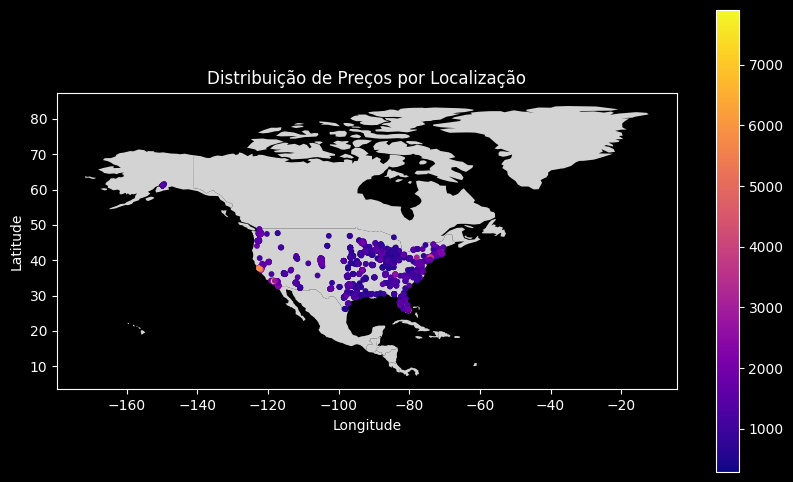

In [309]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Criar uma GeoDataFrame
gdf = gpd.GeoDataFrame(df_train, geometry=gpd.points_from_xy(df_train.longitude, df_train.latitude))

# Substitua pelo caminho do seu arquivo baixado
file_path = "./ne_110m_admin_0_countries.zip"

# Carregar o conjunto de dados de países
world = gpd.read_file(file_path)

# Verifique as colunas disponíveis
print(world.columns)

# Ajuste este filtro com base nas colunas disponíveis
# Por exemplo, se a coluna for 'region_un' em vez de 'continent'
north_america = world[world['CONTINENT'] == 'North America']

# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(10, 6))

# Plotar o mapa da América do Norte
north_america.plot(ax=ax, color='lightgrey')

# Plotar os pontos com a coloração baseada no preço
gdf.plot(ax=ax, column='price', cmap='plasma', markersize=10, legend=True)

# Adicionar título e rótulos
plt.title('Distribuição de Preços por Localização')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.ylim(-60,160)
# plt.xlim(20, 60)

# Exibir o gráfico
plt.show()


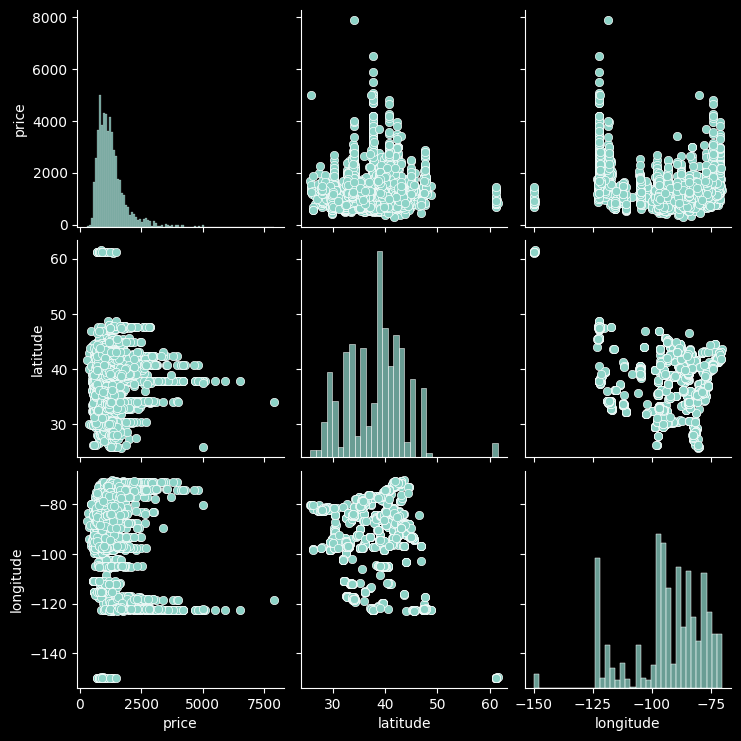

In [310]:
sns.pairplot(df_train[['price', 'latitude', 'longitude']])

Vemos que a localização geográfica é um dado relevante para o modelo, uma vez que a localização do imóvel pode influenciar no preço. Temo uma concentração de valores mais altos na costa oeste dos EUA.

Com a latitude e longitude separadas é possível desconsiderar as variáveis cidade e estado pois as informações de posição geográfica já estarão contempladas. É melhor tratarmos os dados de lat e long para o modelo pois eles representam variáveis numéricas e não categóricas. Comparando com os dados de cidade e estado, temos uma informação muito granular. Todavia, tratar com lat e long pode ser mais complexo, uma vez que a relação entre essas variáveis e o preço pode não ser linear (o que de fato não é). 

Uma alternativa seria criar uma variável que represente a distância do centro da cidade, ou de um ponto de referência, para o imóvel. Isso poderia ser feito a partir de uma biblioteca de geolocalização, como a `geopy`.

Outra alternativa é determinar clusters de localidades, a partir de algoritmos de clusterização, e utilizar esses clusters como variáveis categóricas para o data set de teste.

Vamos tomar a segunda alternativa.

     latitude   longitude        price
0   37.255447  -90.113245   626.040816
1   38.611370  -90.800712  1369.909091
2   40.887064  -77.337536  2209.000000
3   34.872473 -102.853133  1030.933333
4   37.461073  -84.266612  1695.846154
..        ...         ...          ...
95  39.024768  -80.862382  1427.071429
96  37.031583  -84.987585  1021.288462
97  37.941553  -98.787659  1243.875000
98  36.688778  -80.299050  1156.375000
99  40.781125 -120.299525  2260.000000

[100 rows x 3 columns]


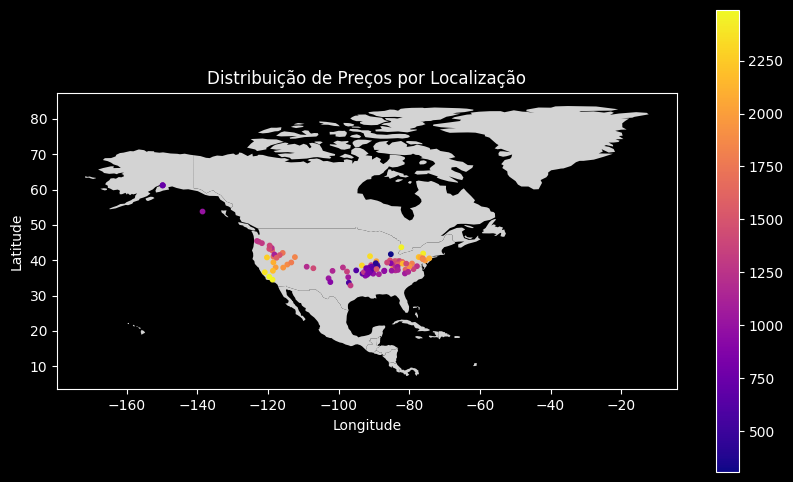

In [367]:
# Definir o número de clusters
num_clusters = 100

# Preparar os dados para o clustering
location_data = df_train[['latitude', 'longitude', 'price']]

# Aplicar o KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_train['location_cluster'] = kmeans.fit_predict(location_data)

# retornar o centro do cluster
location_clusters = pd.DataFrame(kmeans.cluster_centers_, columns=['latitude', 'longitude', 'price'])
print(location_clusters)

gdf = gpd.GeoDataFrame(location_clusters, geometry=gpd.points_from_xy(location_clusters.longitude, location_clusters.latitude))


# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(10, 6))

# Plotar o mapa da América do Norte
north_america.plot(ax=ax, color='lightgrey')

# Plotar os pontos com a coloração baseada no preço
gdf.plot(ax=ax, column='price', cmap='plasma', markersize=10, legend=True)

# Adicionar título e rótulos
plt.title('Distribuição de Preços por Localização')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Exibir o gráfico
plt.show()


# # Verificar os clusters gerados
# df_train[['latitude', 'longitude', 'price', 'location_cluster']].head()

#### Amenities & pets_allowed

Como temos várias opções dentro da coluna `amenities`, vamos segmentar essas informações em colunas separadas para cada amenidade, transformando em uma variável booleana. O mesmo para a coluna `pets_allowed`.

In [312]:
# criando colunas para 'AC', 'Parking' e 'Pool'
df_train['pool'] = df_train['amenities'].str.contains('Pool', case=1, na=0).astype(int)
df_train['ac'] = df_train['amenities'].str.contains('AC', case=1, na=0).astype(int)
df_train['parking'] = df_train['amenities'].str.contains('Parking', case=1, na=0).astype(int)
df_train['hot_tub'] = df_train['amenities'].str.contains('Hot Tub',case=1,na=0).astype(int)
df_train.drop(columns=["amenities"], inplace=True)

# fazendo o mesmo para pets_allowed
df_train['cats'] = df_train['pets_allowed'].str.contains('Cats',case=1,na=0).astype(int)
df_train['dogs'] = df_train['pets_allowed'].str.contains('Dogs',case=1,na=0).astype(int)
df_train.drop(columns=["pets_allowed"], inplace=True)

Vamos avaliar os pares e correlacionar as variáveis via `pairplot`

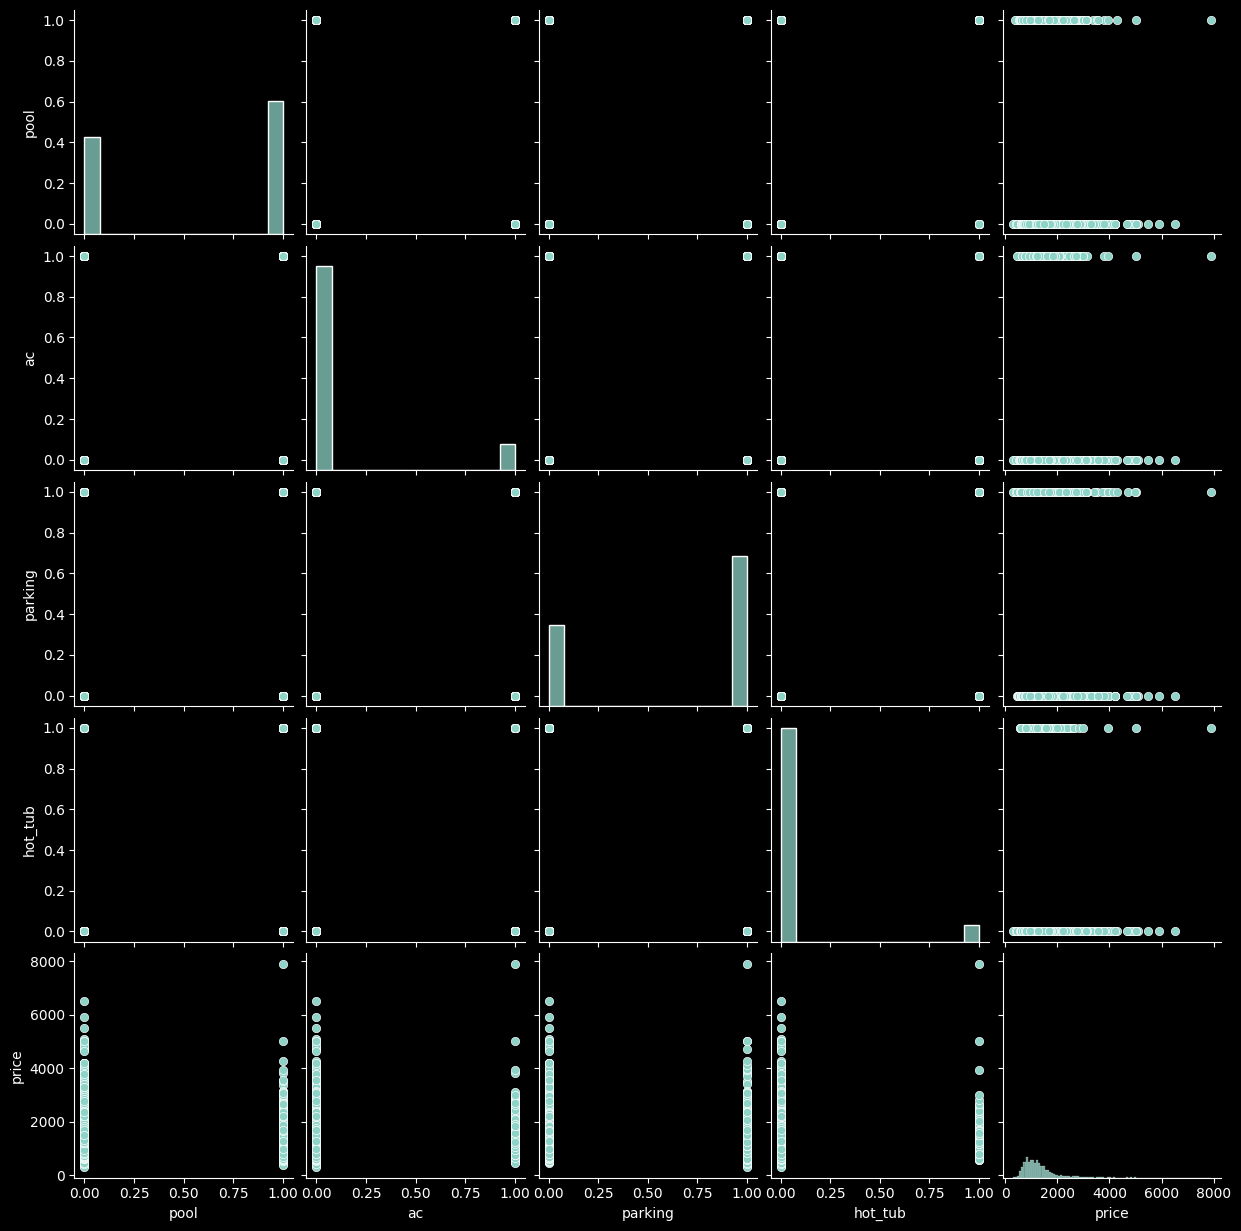

In [313]:
sns.pairplot(df_train[['pool', 'ac', 'parking', 'hot_tub','price']])

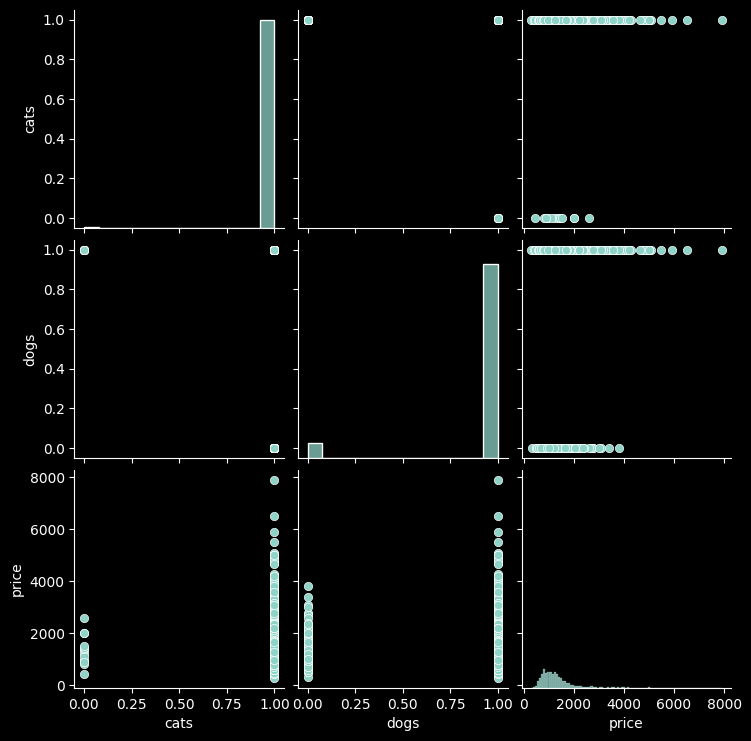

In [314]:
sns.pairplot(df_train[['cats', 'dogs', 'price']])

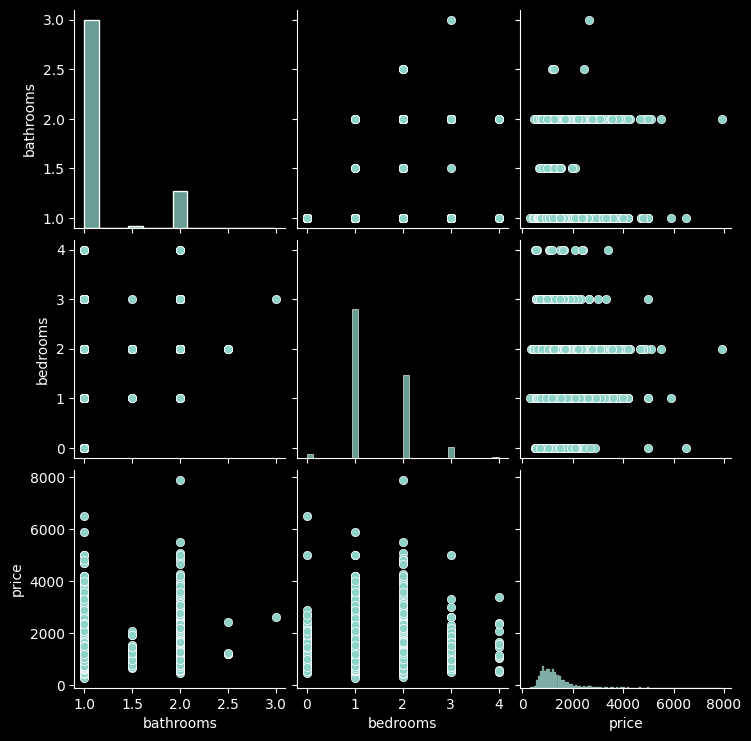

In [315]:
sns.pairplot(df_train[['bathrooms', 'bedrooms', 'price']])

Observa-se que o gráfico de dispersão de preços aparenta ter outliers. Cria-se então o gráfico de boxplot do preço dos imóveis.

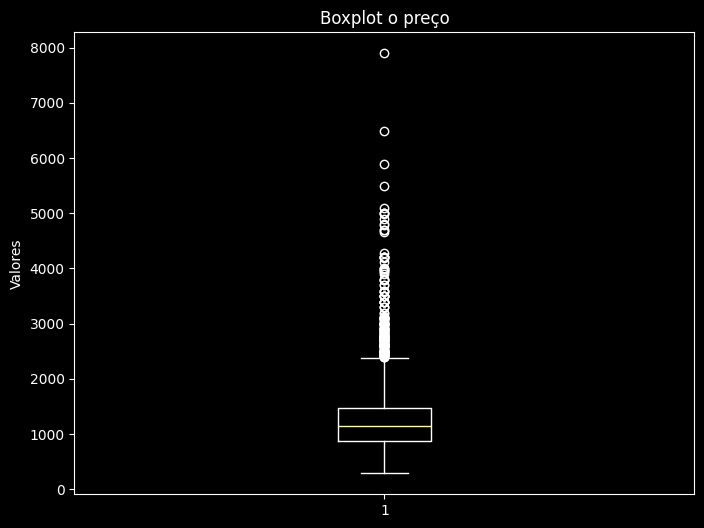

In [316]:
# Criar o boxplot do preço
plt.figure(figsize=(8, 6))
plt.boxplot(df_train['price'])
plt.title('Boxplot o preço')
plt.ylabel('Valores')
plt.show()

De fato o dataframe de treinamento possui muitos outliers. Verifica-se a quantidade de amostras perdidas ao desconsiderar tais outliers do dataframe de treinamento.

In [317]:
print(f"Linhas totais do dataframe: {df_train.shape[0]}")
print(f"Linhas a com valores outliers: {df_train[df_train['price'] > 2500].shape[0]}")
print(f"Percentual de linhas a desconsiderar: {df_train[df_train['price'] > 2500].shape[0]/df_train.shape[0]*100}%")

Linhas totais do dataframe: 3162
Linhas a com valores outliers: 154
Percentual de linhas a desconsiderar: 4.870335230866541%


Como somene 5% dos imóveis possuem preços acima de 2500, tais imóveis serão desconsiderados para o treinamento dos modelos

In [318]:
df_train = df_train[df_train['price'] < 2500]

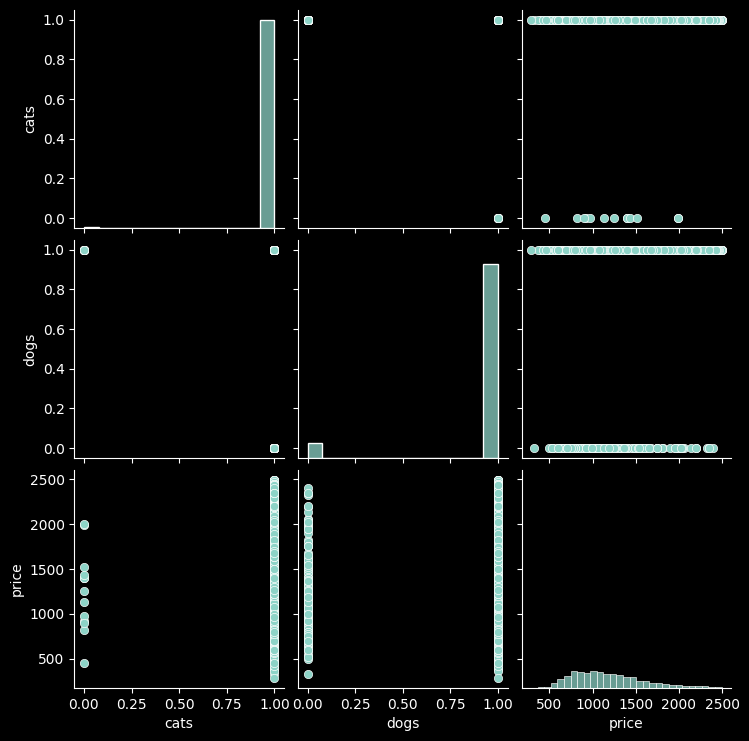

In [319]:
sns.pairplot(df_train.loc[df_train.price < 2500, ['cats','dogs','price']])

Percebe-se que tanto imóveis que aceitam gatos quanto imóveis que aceitam cachorros tendem a ter preços maiores.

In [320]:
df_train['source'].unique()

array(['ListedBuy', 'RentDigs.com', 'RentLingo', 'RENTOCULAR',
       'RealRentals', 'rentbits', 'RENTCaf?1576253157', 'Listanza',
       'tenantcloud'], dtype=object)

In [321]:
df_train.groupby('source',axis=0)['price'].describe()

,count,mean,std,min,25%,50%,75%,max
source,,,,,,,,
Listanza,1.0,1950.000000,NaN,1950.0,1950.0,1950.0,1950.0,1950.0
ListedBuy,17.0,1021.352941,429.020242,665.0,750.0,835.0,1092.0,2093.0
RENTCaf?1576253157,1.0,995.000000,NaN,995.0,995.0,995.0,995.0,995.0
RENTOCULAR,3.0,1631.000000,327.830749,1295.0,1471.5,1648.0,1799.0,1950.0
RealRentals,3.0,1738.666667,352.274514,1332.0,1633.0,1934.0,1942.0,1950.0
RentDigs.com,888.0,1274.912162,414.316319,455.0,980.0,1210.0,1525.0,2495.0
RentLingo,2088.0,1141.157088,402.119237,288.0,825.0,1075.0,1370.0,2495.0
rentbits,2.0,1045.000000,70.710678,995.0,1020.0,1045.0,1070.0,1095.0
tenantcloud,1.0,750.000000,NaN,750.0,750.0,750.0,750.0,750.0


Apesar de existirem diferenças nos preços de fontes distintas, são poucas observações de fontes diferentes de 'RentLingo'. Assim, esse atributo será desconsiderado.

In [322]:
df_train.drop(columns=["source"], inplace=True)

# ficamos assim apenas com as colunas
df_train.columns

Index(['bathrooms', 'bedrooms', 'price', 'square_feet', 'latitude',
       'longitude', 'location_cluster', 'pool', 'ac', 'parking', 'hot_tub',
       'cats', 'dogs'],
      dtype='object')

##### Preparação para o DF de Teste

In [364]:
df_test = pd.read_csv('./apartments_for_rent_test.csv', index_col=0)
df_test = df_test[['amenities', 'bathrooms', 'bedrooms', 'pets_allowed', 'price',
                   'square_feet', 'latitude', 'longitude']]

# Excluindo valores inexistentes
df_test.dropna(inplace=True)

# criando colunas para 'AC', 'Parking' e 'Pool'
df_test['pool'] = df_test['amenities'].str.contains('Pool', case=1, na=0).astype(int)
df_test['ac'] = df_test['amenities'].str.contains('AC', case=1, na=0).astype(int)
df_test['parking'] = df_test['amenities'].str.contains('Parking', case=1, na=0).astype(int)
df_test['hot_tub'] = df_test['amenities'].str.contains('Hot Tub', case=1, na=0).astype(int)

# Processando latitude e longitude
df_test['latitude'] = df_test['latitude']/10
df_test['longitude'] = df_test['longitude'].apply(corrigir_formato)/10
df_test['location_cluster'] = kmeans.fit_predict(df_test[['latitude', 'longitude', 'price']])

# Criando colunas para verificar se aceitam gatos ou cachorros
df_test['cats'] = df_test['pets_allowed'].str.contains('Cats', case=1, na=0).astype(int)
df_test['dogs'] = df_test['pets_allowed'].str.contains('Dogs', case=1, na=0).astype(int)

# Excluindo colunas desnecessarias
df_test.drop(['amenities', 'pets_allowed'], inplace=True, axis=1)
df_test

,bathrooms,bedrooms,price,square_feet,latitude,longitude,pool,ac,parking,hot_tub,location_cluster,cats,dogs
8002,2.0,2.0,1699,1188,34.0072,-84.0034,1,0,0,0,18,1,1
8003,1.0,2.0,1695,1189,43.0724,-89.4003,0,0,1,0,18,1,1
8009,2.0,2.0,1800,1190,43.0724,-89.4003,0,0,1,0,28,1,0
8011,2.0,2.0,1503,1190,37.6202,-77.6128,1,0,1,0,25,1,1
8012,1.0,1.0,1470,1190,32.0057,-102.1036,0,0,1,0,72,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9769,3.0,4.0,1750,2397,30.0021,-95.2555,0,0,0,0,42,1,1
9782,2.0,4.0,1699,2425,32.5942,-96.7624,0,0,0,0,18,1,1
9783,2.0,4.0,1699,2426,34.1241,-84.0331,0,0,0,0,18,1,1
9792,2.0,3.0,1549,2446,32.5900,-96.9436,0,0,0,0,0,1,1


# Modelos

Todos os modelos utilizarão o método de Cross Validation com K-Folds (K=10) para atualização de hiperparâmetros (se aplicável)

In [324]:
df_train = df_train.loc[df_train.price < 2500]
y_train = df_train['price']
X_train = df_train.drop(columns=['price'])

y_test = df_test['price']
X_test = df_test.drop(columns=['price'])

def min_max_normalize(X):
    return (X - X.min()) / (X.max() - X.min())

# y_train = min_max_normalize(y_train)
# y_test = min_max_normalize(y_test)

def calculate_metrics(y_true, y_pred):
    epsilon = 1e-10  # Adicionar uma pequena constante para evitar divisão por zero
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
    return rmse, mae, mape, r2

## KNN
 
 Os modelos KNN se beneficiam de uma normalização dos dados. Vamos normalizar os dados e aplicar o modelo.

In [325]:
X_train = min_max_normalize(X_train)
X_test = min_max_normalize(X_test)

X_train = X_train[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'pool',
       'ac', 'parking', 'hot_tub', 'location_cluster', 'cats', 'dogs']]
X_test = X_test[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'pool',
       'ac', 'parking', 'hot_tub', 'location_cluster', 'cats', 'dogs']]

Best KNN Parameters: {'n_neighbors': 28}
KNN Mean Squared Error: 1301642.652226305


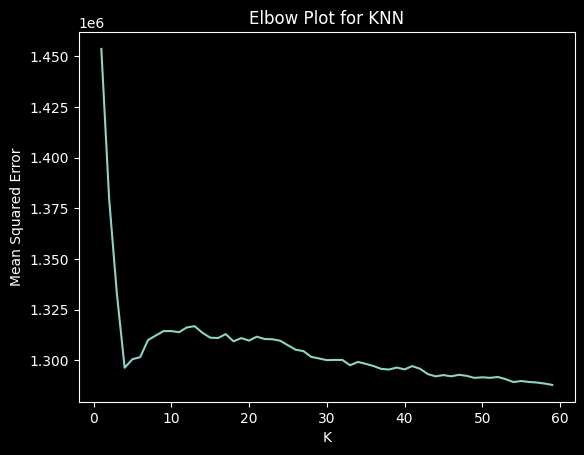

In [326]:
y_train = df_train['price']
X_train = df_train.drop(columns=['price'])

y_test = df_test['price']
X_test = df_test.drop(columns=['price'])

def min_max_normalize(X):
    return (X - X.min()) / (X.max() - X.min())

# y_train = min_max_normalize(y_train)
# y_test = min_max_normalize(y_test)

X_train = min_max_normalize(X_train)
X_test = min_max_normalize(X_test)

X_train = X_train[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'pool',
       'ac', 'parking', 'hot_tub', 'location_cluster', 'cats', 'dogs']]
X_test = X_test[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'pool',
       'ac', 'parking', 'hot_tub', 'location_cluster', 'cats', 'dogs']]


X_train = X_train[[
    # 'bathrooms',
    'bedrooms',
    'square_feet',
    # 'latitude',
    # 'longitude',
    'location_cluster',
    'pool',
    # 'ac',
    # 'parking',
    # 'hot_tub',
    'cats',
    # 'dogs'
]]
X_test = X_test[[
    # 'bathrooms',
    'bedrooms',
    'square_feet',
    # 'latitude',
    # 'longitude',
    'location_cluster',
    'pool',
    # 'ac',
    # 'parking',
    # 'hot_tub',
    'cats',
    # 'dogs'
]]

# Define the range of K values
k_values = range(1, 60)

# Definir os hiperparâmetros a serem ajustados
knn_params = {'n_neighbors': range(1, 31)}

# Inicializar o modelo
knn = KNeighborsRegressor()

# Configurar a validação cruzada com GridSearchCV
knn_grid = GridSearchCV(knn, knn_params, cv=10,
                        scoring='neg_mean_squared_error', n_jobs=-1)

# Treinar o modelo
knn_grid.fit(X_train, y_train)

# Melhor hiperparâmetro
print("Best KNN Parameters:", knn_grid.best_params_)

# Prever no conjunto de teste
knn_predictions = knn_grid.predict(X_test)

# Avaliar o modelo
knn_mse = mean_squared_error(y_test, knn_predictions)
print("KNN Mean Squared Error:", knn_mse)


# Definir os hiperparâmetros a serem ajustados
knn_params = {'n_neighbors': range(1, 31)}

# Initialize an empty list to store the MSE values
mse_values = []

# Calculate the MSE for each K value
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_predictions = knn.predict(X_test)
    mse = mean_squared_error(y_test, knn_predictions)
    mse_values.append(mse)

# Plot the elbow plot
plt.plot(k_values, mse_values)
plt.xlabel('K')
plt.ylabel('Mean Squared Error')
plt.title('Elbow Plot for KNN')
plt.show()


# KNN
knn_train_rmse, knn_train_mae, knn_train_mape, knn_train_r2 = calculate_metrics(y_train, knn_grid.predict(X_train))
knn_test_rmse, knn_test_mae, knn_test_mape, knn_test_r2 = calculate_metrics(y_test, knn_grid.predict(X_test))

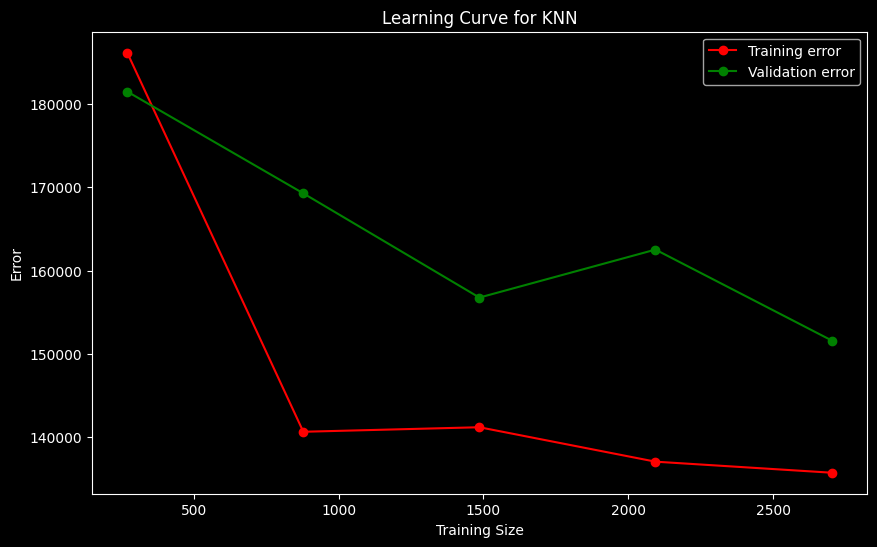

In [327]:
from sklearn.model_selection import learning_curve

# Calcular a curva de aprendizado
train_sizes, train_scores, valid_scores = learning_curve(knn_grid.best_estimator_, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Calcular as médias dos scores de treino e validação
train_scores_mean = -train_scores.mean(axis=1)
valid_scores_mean = -valid_scores.mean(axis=1)

# Plotar a curva de aprendizado
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, valid_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training Size')
plt.ylabel('Error')
plt.title('Learning Curve for KNN')
plt.legend(loc='best')
plt.show()


## Decision Tree


In [328]:
# preparacao dos dados
df_train = df_train.loc[df_train.price < 2500]
y_train = df_train['price']
X_train = df_train.drop(columns=['price'])

y_test = df_test['price']
X_test = df_test.drop(columns=['price'])


def min_max_normalize(X):
    return (X - X.min()) / (X.max() - X.min())


# y_train = min_max_normalize(y_train)
# y_test = min_max_normalize(y_test)

X_train = min_max_normalize(X_train)
X_test = min_max_normalize(X_test)

X_train = X_train[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'pool',
                   'ac', 'parking', 'hot_tub', 'location_cluster', 'cats', 'dogs']]
X_test = X_test[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'pool',
                 'ac', 'parking', 'hot_tub', 'location_cluster', 'cats', 'dogs']]

In [329]:
# Definir os hiperparâmetros a serem ajustados
tree_params = {'max_depth': range(1, 8), 'min_samples_split': range(2, 21)}

# Inicializar o modelo
tree = DecisionTreeRegressor()

# Configurar a validação cruzada com GridSearchCV
tree_grid = GridSearchCV(tree, tree_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# Treinar o modelo
tree_grid.fit(X_train, y_train)

# Melhor hiperparâmetro
print("Best Decision Tree Parameters:", tree_grid.best_params_)

# Prever no conjunto de teste
tree_predictions = tree_grid.predict(X_test)

# Avaliar o modelo
tree_mse = mean_squared_error(y_test, tree_predictions)
print("Decision Tree Mean Squared Error:", tree_mse)

Best Decision Tree Parameters: {'max_depth': 7, 'min_samples_split': 4}
Decision Tree Mean Squared Error: 1405853.926249659


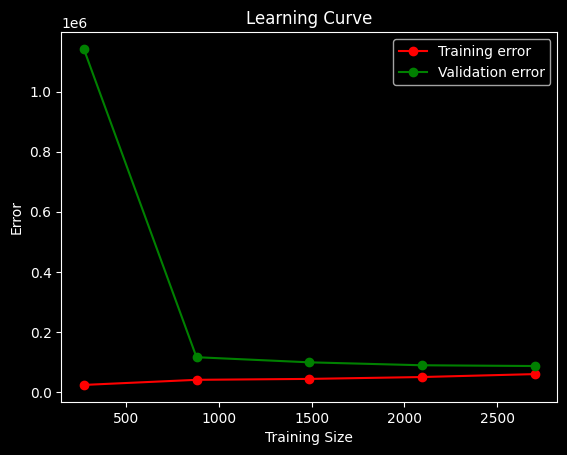

In [330]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(tree_grid.best_estimator_, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis=1)
valid_scores_mean = -valid_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, valid_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training Size')
plt.ylabel('Error')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()


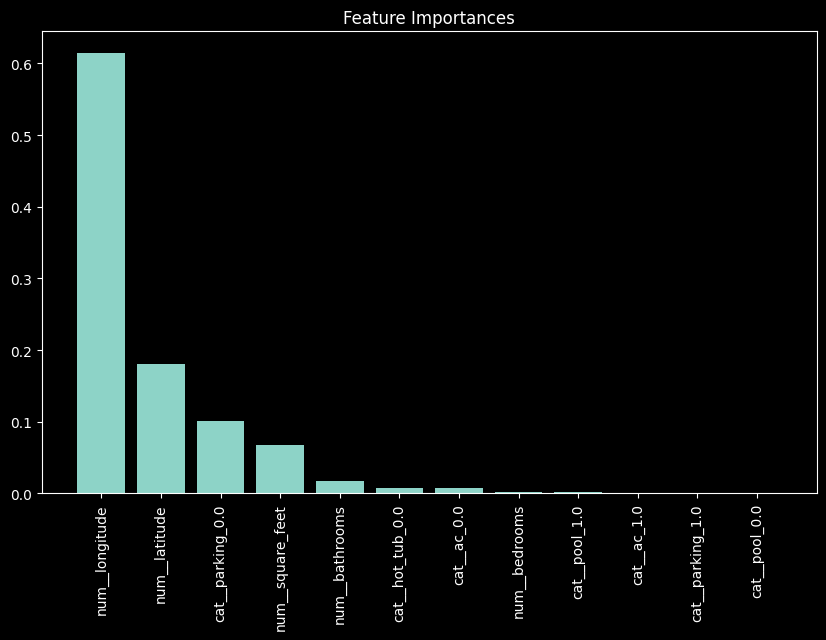

In [331]:
num_cols = ['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude']
cat_cols = ['pool', 'ac', 'parking', 'hot_tub', 'cats', 'dogs', 'location_cluster']

preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ])

preprocessor_tree.fit(X_train)

importances = tree_grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = preprocessor_tree.get_feature_names_out()

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


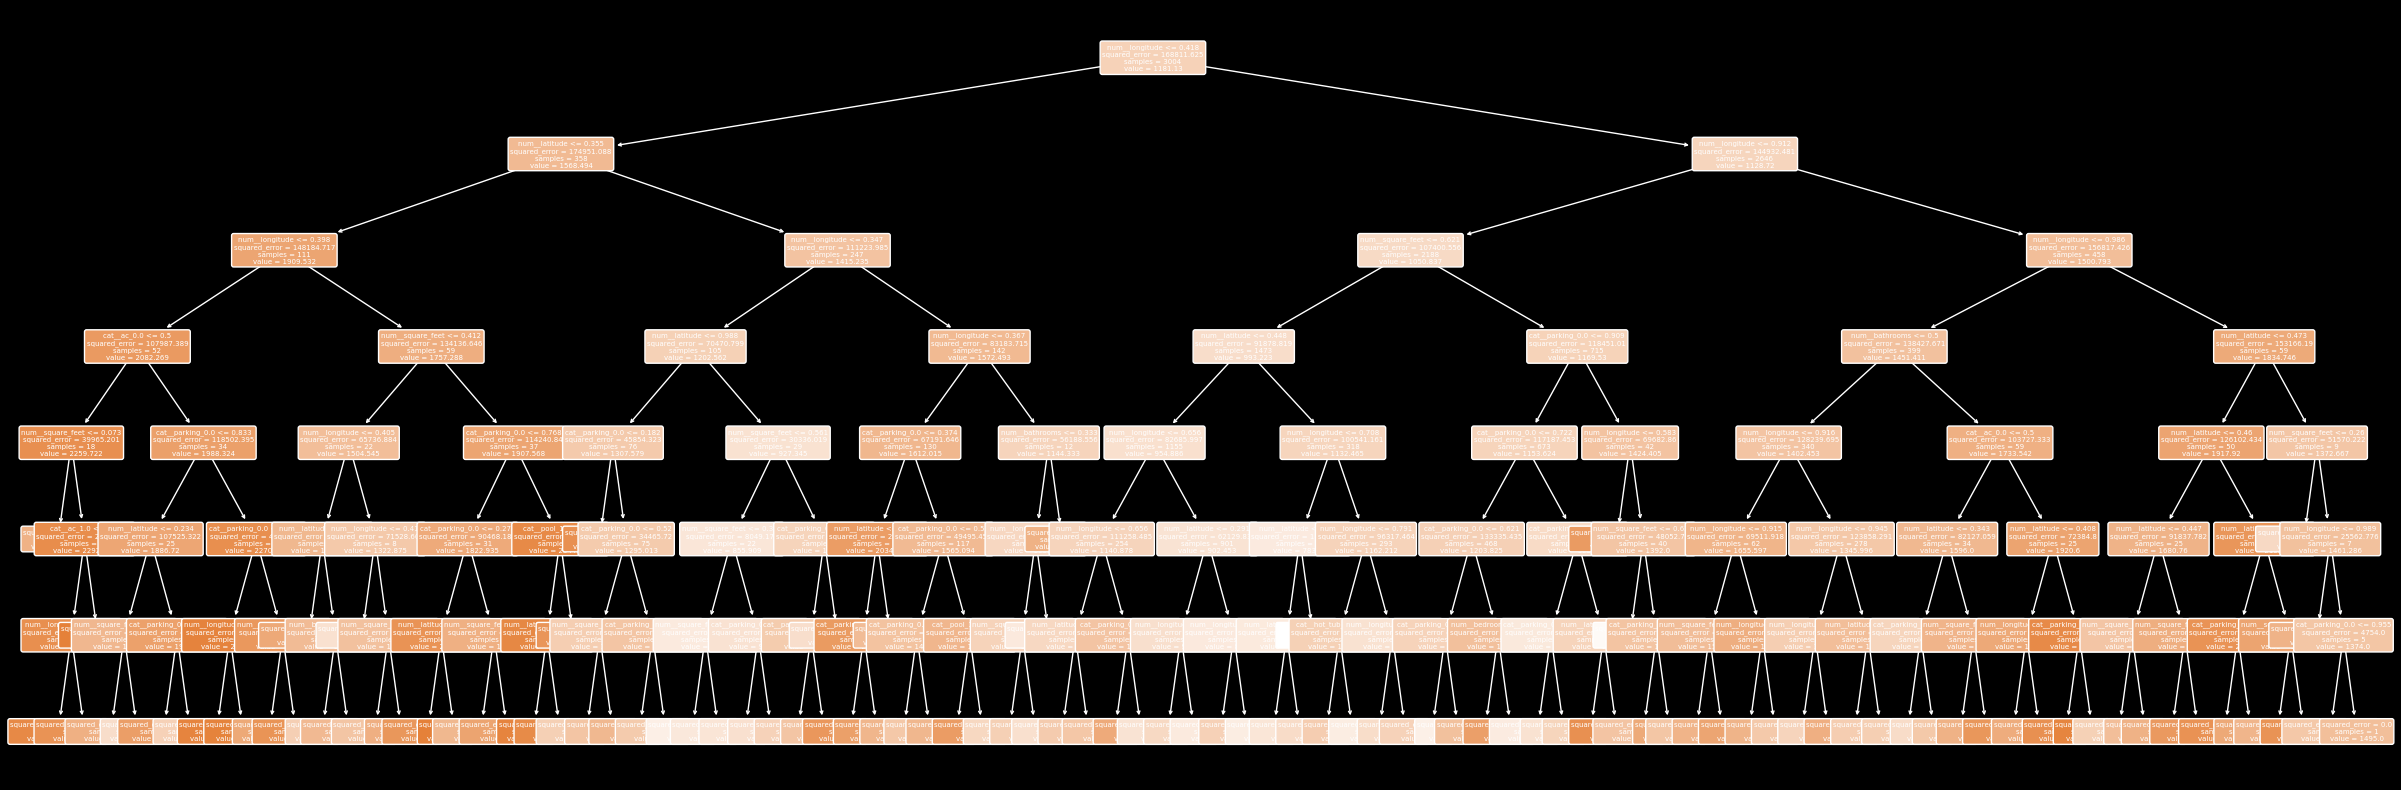

In [332]:
from sklearn.tree import plot_tree

# Supondo que você já treinou o modelo e ele está armazenado em `tree_grid`
best_tree_model = tree_grid.best_estimator_

# Visualizar a árvore de decisão
plt.figure(figsize=(30,10))
plot_tree(best_tree_model, 
          filled=True, 
          feature_names=preprocessor_tree.get_feature_names_out(), 
          rounded=True, 
          fontsize=5)
plt.show()


In [333]:
# Decision Tree
tree_train_rmse, tree_train_mae, tree_train_mape, tree_train_r2 = calculate_metrics(y_train, tree_grid.predict(X_train))
tree_test_rmse, tree_test_mae, tree_test_mape, tree_test_r2 = calculate_metrics(y_test, tree_grid.predict(X_test))

## Support Vector Machine (SVM)

In [334]:
# alterando features
# retirando bathrooms, latitude, longitude, ac, parking, hot_tub e dogs

X_train = X_train[['bedrooms', 'square_feet',
                   'pool', 'location_cluster', 'cats']]
X_test = X_test[['bedrooms', 'square_feet',
                 'pool', 'location_cluster', 'cats']]

# Definir os hiperparâmetros a serem ajustados
svm_params = {'C': [0.1, 1, 10, 100], 'epsilon': [
    0.1, 0.2, 0.3], 'kernel': ['linear', 'poly', 'rbf']}

# Inicializar o modelo
svm = SVR()

# Configurar a validação cruzada com GridSearchCV
svm_grid = GridSearchCV(svm, svm_params, cv=10,
                        scoring='neg_mean_squared_error', n_jobs=-1)

# Treinar o modelo
svm_grid.fit(X_train, y_train)

# Melhor hiperparâmetro
print("Best SVM Parameters:", svm_grid.best_params_)

# Prever no conjunto de teste
svm_predictions = svm_grid.predict(X_test)

# Avaliar o modelo
svm_mse = mean_squared_error(y_test, svm_predictions)
print("SVM Mean Squared Error:", svm_mse)

Best SVM Parameters: {'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'}
SVM Mean Squared Error: 1426632.1629222797


In [335]:
# SVM
svm_train_rmse, svm_train_mae, svm_train_mape, svm_train_r2 = calculate_metrics(y_train, svm_grid.predict(X_train))
svm_test_rmse, svm_test_mae, svm_test_mape, svm_test_r2 = calculate_metrics(y_test, svm_grid.predict(X_test))

In [336]:
# Comparando os modelos
print("Resumo do Desempenho dos Modelos:")
print(f"KNN Mean Squared Error: {knn_mse*100:.2f}")
print(f"Decision Tree Mean Squared Error: {tree_mse*100:.2f}")
print(f"SVM Mean Squared Error: {svm_mse*100:.2f}")

Resumo do Desempenho dos Modelos:
KNN Mean Squared Error: 130164265.22 %
Decision Tree Mean Squared Error: 140585392.62 %
SVM Mean Squared Error: 142663216.29 %


## MLP

In [379]:
import warnings
warnings.filterwarnings('ignore')

# preparacao dos dados
df_train = df_train.loc[df_train.price < 2500]
y_train = df_train['price']
X_train = df_train.drop(columns=['price'])

y_test = df_test['price']
X_test = df_test.drop(columns=['price'])


def min_max_normalize(X):
    return (X - X.min()) / (X.max() - X.min())

# y_train = min_max_normalize(y_train)
# y_test = min_max_normalize(y_test)


X_train = min_max_normalize(X_train)
X_test = min_max_normalize(X_test)

X_train = X_train[['bathrooms',
                   'bedrooms',
                   'square_feet',
                   'latitude',
                   'longitude',
                #    'pool',
                #    'ac',
                #    'parking',
                #    'hot_tub',
                #    'location_cluster',
                #    'cats',
                #    'dogs'
                   ]]
X_test = X_test[['bathrooms',
                 'bedrooms',
                 'square_feet',
                 'latitude',
                 'longitude',
                #  'pool',
                #  'ac',
                #  'parking',
                #  'hot_tub',
                #  'location_cluster',
                #  'cats',
                #  'dogs'
                 ]]

param_grid = {
    'hidden_layer_sizes': [(50,), (100,)],
    'alpha': [0.0001, 0.001],
    'solver': ['adam'],
    'learning_rate': ['constant', 'adaptive'],
}


# Criando o modelo

mlp_grid = GridSearchCV(MLPRegressor(
    max_iter=300, random_state=42), param_grid, cv=10, n_jobs=-1)
mlp_grid.fit(X_train, y_train)

# Melhor combinação de hiperparâmetros
print(f'Melhores hiperparâmetros: {mlp_grid.best_params_}')

# Avaliar a precisão no conjunto de teste
best_model = mlp_grid.best_estimator_
mlp_predictions = best_model.predict(X_test)

# Avaliar o modelo
mlp_mse = mean_squared_error(y_test, mlp_predictions)
print("MLP Mean Squared Error:", mlp_mse)

# MLP
mlp_train_rmse, mlp_train_mae, mlp_train_mape, mlp_train_r2 = calculate_metrics(
    y_train, mlp_grid.predict(X_train))
mlp_test_rmse, mlp_test_mae, mlp_test_mape, mlp_test_r2 = calculate_metrics(
    y_test, mlp_grid.predict(X_test))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

Melhores hiperparâmetros: {'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
MLP Mean Squared Error: 18486117.714525945


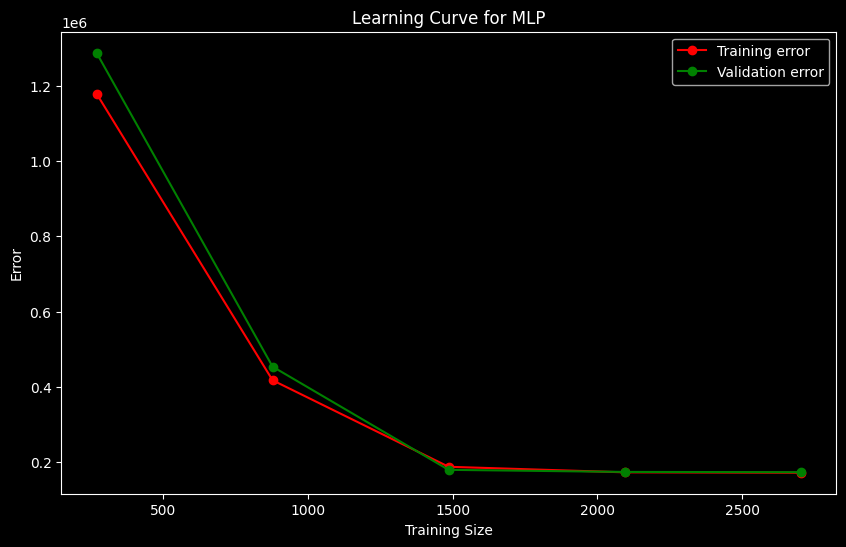

In [380]:
# Calcular a curva de aprendizado
train_sizes, train_scores, valid_scores = learning_curve(mlp_grid.best_estimator_, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Calcular as médias dos scores de treino e validação
train_scores_mean = -train_scores.mean(axis=1)
valid_scores_mean = -valid_scores.mean(axis=1)

# Plotar a curva de aprendizado
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, valid_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training Size')
plt.ylabel('Error')
plt.title('Learning Curve for MLP')
plt.legend(loc='best')
plt.show()


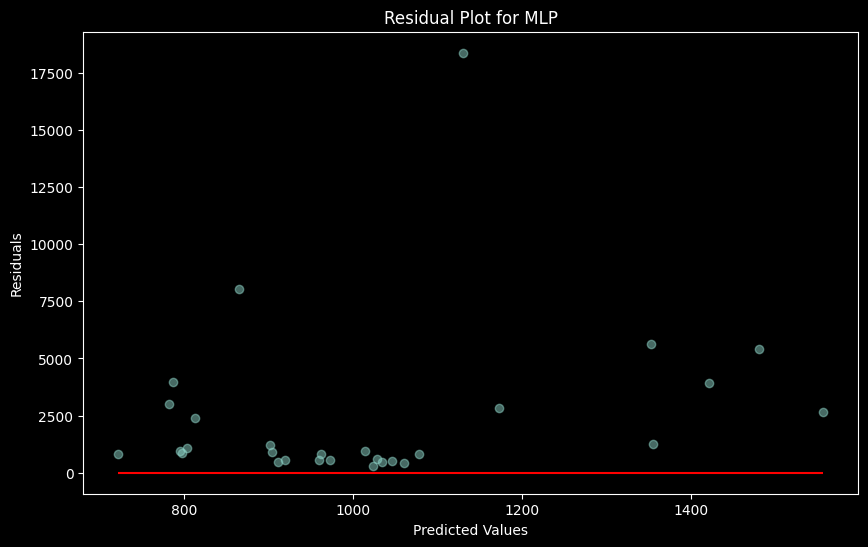

In [381]:
# Prever no conjunto de teste usando o melhor modelo MLP
mlp_predictions = mlp_grid.predict(X_test)

# Calcular os resíduos
residuals = y_test - mlp_predictions

# Plotar o gráfico de resíduos
plt.figure(figsize=(10, 6))
plt.scatter(mlp_predictions, residuals, alpha=0.5)
plt.hlines(y=0, xmin=mlp_predictions.min(), xmax=mlp_predictions.max(), colors='r')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for MLP')
plt.show()


## Random Forest

In [384]:
import warnings
warnings.filterwarnings('ignore')

# preparacao dos dados 
df_train = df_train.loc[df_train.price < 2500]
y_train = df_train['price']
X_train = df_train.drop(columns=['price'])

y_test = df_test['price']
X_test = df_test.drop(columns=['price'])

def min_max_normalize(X):
    return (X - X.min()) / (X.max() - X.min())

# y_train = min_max_normalize(y_train)
# y_test = min_max_normalize(y_test)

X_train = min_max_normalize(X_train)
X_test = min_max_normalize(X_test)

X_train = X_train[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'pool',
       'ac', 'parking', 'hot_tub', 'location_cluster', 'cats', 'dogs']]
X_test = X_test[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'pool',
       'ac', 'parking', 'hot_tub', 'location_cluster', 'cats', 'dogs']]

## Criando o modelo de random forest

param_grid = {
    'n_estimators': [50,100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [5, 12, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4, 8],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1)

rf_grid.fit(X_train, y_train)

# Avaliar a precisão no conjunto de teste
best_model = rf_grid.best_estimator_
rf_predictions = best_model.predict(X_test)

# Avaliar o modelo
rf_mse = mean_squared_error(y_test, rf_predictions)
print("Random Forest Mean Squared Error:", rf_mse)

Random Forest Mean Squared Error: 17268285.881452356


In [347]:
# Random Forest
rf_train_rmse, rf_train_mae, rf_train_mape, rf_train_r2 = calculate_metrics(y_train, rf_grid.predict(X_train))
rf_test_rmse, rf_test_mae, rf_test_mape, rf_test_r2 = calculate_metrics(y_test, rf_grid.predict(X_test))


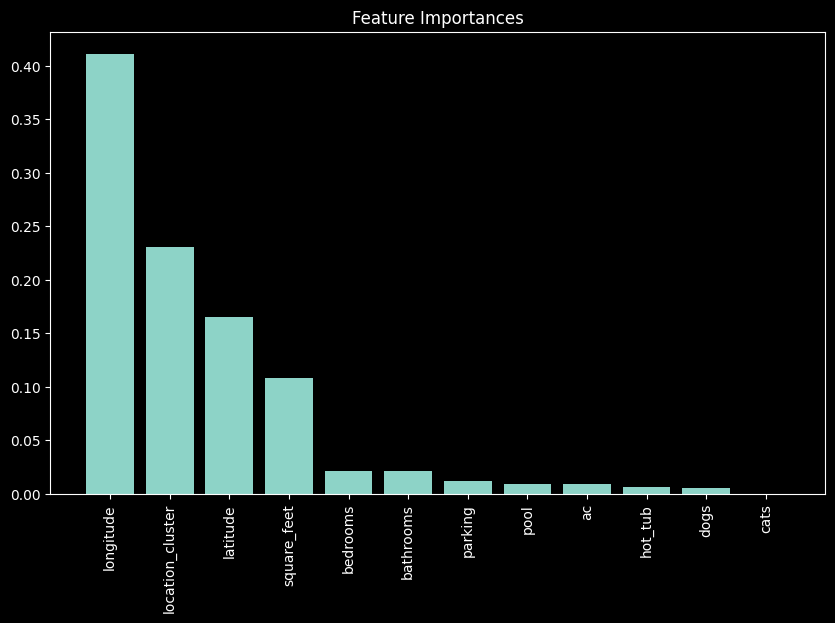

In [348]:
# Importância das features
importances = rf_grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

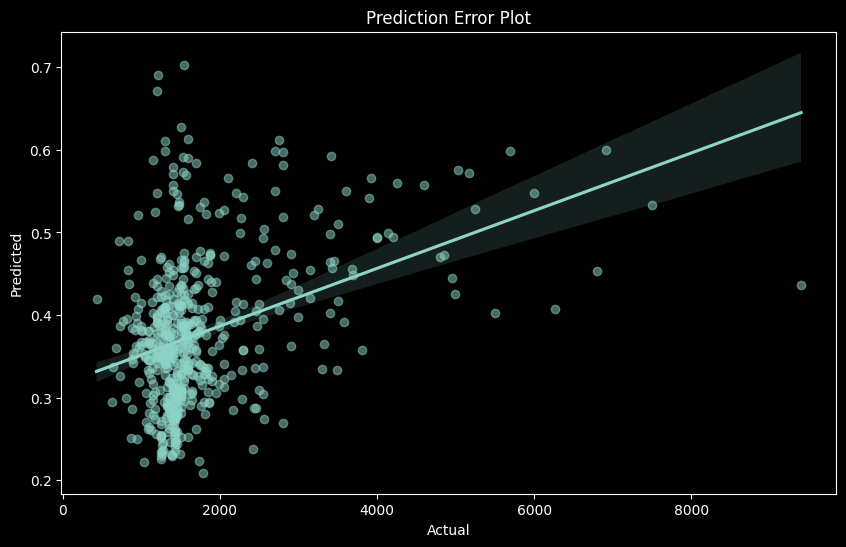

In [343]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=rf_predictions, scatter_kws={'alpha':0.5})
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Prediction Error Plot')
plt.show()


# Resultados

In [383]:
# Criar uma tabela estruturada
data = {
    'Model': ['KNN', 'Decision Tree', 'SVM', 'MLP', 'Random Forest'],
    'Train RMSE': [knn_train_rmse, tree_train_rmse, svm_train_rmse, mlp_train_rmse, rf_train_rmse],
    'Test RMSE': [knn_test_rmse, tree_test_rmse, svm_test_rmse, mlp_test_rmse, rf_test_rmse],
    'Train MAE': [knn_train_mae, tree_train_mae, svm_train_mae, mlp_train_mae, rf_train_mae],
    'Test MAE': [knn_test_mae, tree_test_mae, svm_test_mae, mlp_test_mae, rf_test_mae],
    'Train MAPE': [knn_train_mape, tree_train_mape, svm_train_mape, mlp_train_mape, rf_train_mape],
    'Test MAPE': [knn_test_mape, tree_test_mape, svm_test_mape, mlp_test_mape, rf_test_mape],
    'Train R²': [knn_train_r2, tree_train_r2, svm_train_r2, mlp_train_r2, rf_train_r2],
    'Test R²': [knn_test_r2, tree_test_r2, svm_test_r2, mlp_test_r2, rf_test_r2]
}

metrics_df = pd.DataFrame(data)
metrics_df = metrics_df.set_index('Model')
metrics_df = metrics_df.applymap(lambda x: f'{x:.3f}')

metrics_df[['Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE','Train MAPE', 'Test MAPE', 'Train R²', 'Test R²']]


,Train RMSE,Test RMSE,Train MAE,Test MAE,Train MAPE,Test MAPE,Train R²,Test R²
Model,,,,,,,,
KNN,367.530,1140.896,278.031,677.051,26.182,31.087,0.200,-0.466
Decision Tree,245.006,1185.687,180.457,837.221,17.214,43.968,0.644,-0.583
SVM,400.184,1194.417,307.794,763.331,27.492,36.313,0.051,-0.606
MLP,413.535,4299.549,321.742,2425.650,29.911,54.970,-0.013,-0.419
Random Forest,129.878,4098.545,91.497,2167.187,8.895,44.453,0.900,-0.290


# Rodando o arquivo de teste no dia D


In [371]:
df_test = pd.read_csv('./apartments_for_rent_final_test.csv', index_col=0)
df_test = df_test[['amenities', 'bathrooms', 'bedrooms', 'pets_allowed', 'price',
                   'square_feet', 'latitude', 'longitude']]

# Excluindo valores inexistentes
df_test.dropna(inplace=True)

# criando colunas para 'AC', 'Parking' e 'Pool'
df_test['pool'] = df_test['amenities'].str.contains('Pool', case=1, na=0).astype(int)
df_test['ac'] = df_test['amenities'].str.contains('AC', case=1, na=0).astype(int)
df_test['parking'] = df_test['amenities'].str.contains('Parking', case=1, na=0).astype(int)
df_test['hot_tub'] = df_test['amenities'].str.contains('Hot Tub', case=1, na=0).astype(int)

# Processando latitude e longitude
df_test['latitude'] = df_test['latitude']/10
df_test['longitude'] = df_test['longitude'].apply(corrigir_formato)/10
df_test['location_cluster'] = kmeans.predict(df_test[['latitude', 'longitude', 'price']])

# Criando colunas para verificar se aceitam gatos ou cachorros
df_test['cats'] = df_test['pets_allowed'].str.contains('Cats', case=1, na=0).astype(int)
df_test['dogs'] = df_test['pets_allowed'].str.contains('Dogs', case=1, na=0).astype(int)

# Excluindo colunas desnecessarias
df_test.drop(['amenities', 'pets_allowed'], inplace=True, axis=1)
# df_test

In [376]:
y_test = df_test['price']
X_test = df_test.drop(columns=['price'])

X_test = min_max_normalize(X_test)

X_test = X_test[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'pool',
       'ac', 'parking', 'hot_tub', 'location_cluster', 'cats', 'dogs']]
rf_test_rmse, rf_test_mae, rf_test_mape, rf_test_r2 = calculate_metrics(y_test, rf_grid.predict(X_test))

print(f'Random Forest')
print(f'\tRMSE:    {rf_test_rmse:.3f}')
print(f'\tMAE:     {rf_test_mae:.3f}')
print(f'\tMAPE:    {rf_test_mape:.3f} %')
print(f'\tR²:      {rf_test_r2:.3f}')


Random Forest
	RMSE:    4098.545
	MAE:     2167.187
	MAPE:    44.453 %
	R²:      -0.290
